Note:This is continuation of UCS tutorial. 

Let us quickly recap the problem we solved and UCS. Below is the map, and we needed to find a path from Arad to Bucharest. Note it is no more a tree, but a graph (includes closed ends) which we saw at end of UCS tutorial. 

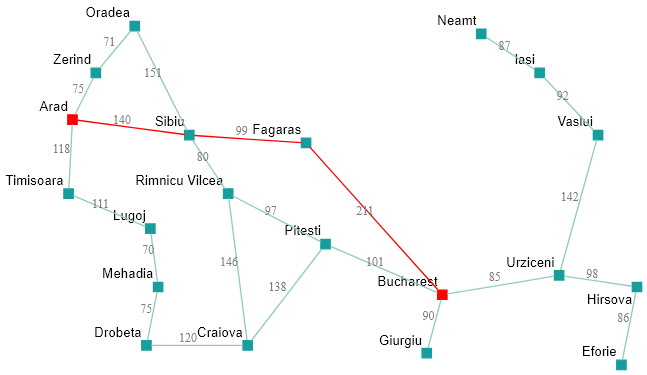

In [1]:
#storing above map info first as a dictionary..
romania_nodes_map = {
        'A': [(140,'S'),(118,'T'),(75,'Z')],
        'S': [(99,'F'),(80,'RV'),(151,'O')],
        'T': [(111,'LU')],
        'Z': [(71,'O')],
        'F': [(211,'B')],
        'B': [(90,'G'),(85,'U')],
        'U':[(98,'H'),(142,'V')],
        'V':[(92,'LA')],
        'LA':[(87,'N')],
        'RV':[(146,'C'),(97,'P')],
        'P':[(101,'B'),(138,'C')],
        'LU':[(70,'M')],
        'M':[(75,'D')],
        'D':[(120,'C')],
        'H':[(86,'E')]
        }

from queue import PriorityQueue
q = PriorityQueue()
start = 'A'
goal = 'B'
q.put((0,start))
cameFrom = {}           #note its a dict, not list caz key needed as string. Its 'kid':'papa'
cameFrom[start] = None  #caz its a starting point in our virtual tree of search!! No papa.
closedSet = set()  # set() would be better than a list?

while not q.empty():
    current_cost, current_path = q.get() #cost is inf, path is ['A']
    current_node = current_path[-1]      #this should give us 'A'

    #Is 'A' is not goal 'B'? 
    if (current_node == goal): 
        break 
    else:
        #if current_node in closedSet: print('Duplicate Avoided')  #just to ensure loops really avoided..
        closedSet.add(current_node)

    for each_children in romania_nodes_map.get(current_node, []):
        q.put((current_cost + each_children[0], each_children[1]))
        cameFrom[each_children[1]]=current_node

    #test
    list(q.queue)

print(current_cost, current_node)
path = [current_node]
while current_node != None:   #when current_node is not None..
    current_node = cameFrom[current_node]
    path.append(current_node)
print(current_cost, [x for x in reversed(path[:-1])])

450 B
450 ['A', 'S', 'F', 'B']


Now, looking at the graph, we get it. The path A - S - F - B is good, it gets us to the goal with cost of 450. But one might also catch an alternative path with lesser cost. Check below map. This costs only <span style="color:red">418 (140+80+97+101)</span>

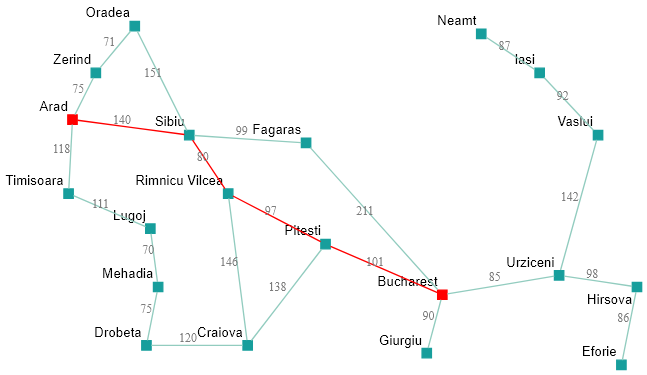

Wouldn't it better if our algorithm finds this shortest path than just a path that takes us to the goal? This is what A star achieves. 

A star does this by incorporating a pending estimate to the goal every time we choose next best node to hop to.

That is, every time we add a new node to the queue with total cost to arrive there, we will also now include

**new_cost = total_cost + pending_estimation_to_goal**

Shortly
**f(n) = g(n) + h(n)**

where
f(n) is new cost calculated for node being added to Q
g(n) is total cost so far from start to this node that is being added to Q
h(n) is the pending estimation from this node being added to Q to the goal 

h(n) is called the heuristic function. The efficiency of algorithm depends on how good the heuristic fucntion is. 

Heuristic function for a goal location in map could be its straight line distance from start location. So we will modify our map
1) to be relatively placed according to their (latitude, longitude)
2) Distance between connected cities calculated as straight line distance, shortly called SLD
3) Heuristic Distance from start city to goal city h(n) shall be calculated again as straight line distance

Note that we do SLD because, between 2 points in a reference spatial system, the shortest distance is always the straight line between them. This way, **our h(n) would be always less than actual distance** thus, every moment we have to decide next node, it makes sense to choose least cost path f(n). 

Also, connected cities taken as SLDs to have equal weightage for both g(n) and h(n). This changes the already seen costs between cities earlier.

Below is modified map using Plotly and networkx libraries. Note our dictionary also now has been modified to include only lat,lon and neighbours, since its no more needed to hard code position (as they are calculated as SLDs anyway). 

In [2]:
from helper_parthi2929 import *


romania_location_map = {
    'A' : {'pos': (21.31227,46.18656), 'connections': ['S','T','Z'] },
    'S' : {'pos': (24.12558,45.79833), 'connections': ['F','RV','O'] },
    'Z' : {'pos': (21.51742,46.62251), 'connections': ['O'] },
    'T' : {'pos': (21.20868,45.74887), 'connections': ['LU'] },
    'O' : {'pos': (21.91894,47.04650), 'connections': [] },
    'F' : {'pos': (24.97310,45.84164), 'connections': ['B'] },
    'LU' : {'pos': (21.90346,45.69099), 'connections': ['M'] },
    'RV' : {'pos': (24.36932,45.09968), 'connections': ['C','P'] },
    'M' : {'pos': (22.36452,44.90411), 'connections': ['D'] },
    'D' : {'pos': (22.65973,44.63692), 'connections': ['C'] },
    'C' : {'pos': (23.79488,44.33018), 'connections': [] },
    'P' : {'pos': (24.86918,44.85648), 'connections': ['B','C'] },
    'B' : {'pos': (26.10254,44.42677), 'connections': ['G','U'] },
    'G' : {'pos': (25.96993,43.90371), 'connections': [] },
    'U' : {'pos': (26.64112,44.71653), 'connections': ['H','V'] },
    'V' : {'pos': (27.72765,46.64069), 'connections': ['LA'] },
    'LA' : {'pos':(27.60144,47.15845), 'connections': ['N'] },
    'N' : {'pos': (26.38188,46.97587), 'connections': [] },
    'H' : {'pos': (27.94566,44.68935), 'connections': ['E'] },
    'E' : {'pos': (28.65273,44.04911), 'connections': [] }
}

graph = load_map_graph(romania_location_map)
#show_map(graph, start='A',goal='B',path=['A','S','F','B'],SLDTarget='B')
show_map(graph)

Let us have a function to implement the SLDs between cities as below (thank you geodesic, as its not straight forward Euclidean like to calculate distance between two geo spatial points)

In [3]:
# calculating geodesic SLDs
import geopy.distance
def calculate_GD(start, end):

    (x0,y0) = graph.node[start]['pos']
    (x1,y1) = graph.node[end]['pos']
    return floor(geopy.distance.geodesic((y0,x0), (y1,x1)).miles)

Let us try calculate SLD between Arad and Bucharest..

In [4]:
calculate_GD('A','B')

263

Similarly we could calculate for all cities to Bucharest and those would be as below show in red..

In [5]:
show_map(graph, start='A',goal='B',SLDTarget='B')

We shall first modify our traversal of graph, as our map structure changed. Let us test below one..

In [6]:
for each_node in romania_location_map.keys():
    for each_child in romania_location_map[each_node]['connections']:
        print('Current node: {} Its Kid: {}'.format(each_node,each_child))

Current node: A Its Kid: S
Current node: A Its Kid: T
Current node: A Its Kid: Z
Current node: S Its Kid: F
Current node: S Its Kid: RV
Current node: S Its Kid: O
Current node: Z Its Kid: O
Current node: T Its Kid: LU
Current node: F Its Kid: B
Current node: LU Its Kid: M
Current node: RV Its Kid: C
Current node: RV Its Kid: P
Current node: M Its Kid: D
Current node: D Its Kid: C
Current node: P Its Kid: B
Current node: P Its Kid: C
Current node: B Its Kid: G
Current node: B Its Kid: U
Current node: U Its Kid: H
Current node: U Its Kid: V
Current node: V Its Kid: LA
Current node: LA Its Kid: N
Current node: H Its Kid: E


Hmm, but we do not traverse that way in our algo. We take a specific current node, look up for that as key in dictionary and pick its children. Below one was found after a trial and error (so do not know if it would break some time later)

In [7]:
for each_child in romania_location_map.get('A',[]).get('connections',[]):
    print('Current node: {} Its Kid: {}'.format('A',each_child))

Current node: A Its Kid: S
Current node: A Its Kid: T
Current node: A Its Kid: Z


And we do not have cost stored in dictionary unlike earlier case.. So we will calculate dynamically as follows for each iteration..
```python
# f(n) = g(n) + h(n)
# g(n) = total actual SLD so far from 'start' to 'current kid'
# h(n) = SLD from current node to 'goal'
```

g(n) is gonna be tricky because we already do not have costs stored in our map to just add to cost during iteration (check each_children[0] being added to cost). 

Remember from our algo, pQ stores the cost(as priority) and the path from 'start' to 'current node'. We could calculate the cost so far from this path info and calculating 'step cost' for each edge. 
```python
# g(n) = calculate_totalGD(current_node) + calculate_GD(graph, current_node, current_kid)
```
And calculate_cost_from_path can make use of cameFrom array we are storing in each iteration. Since all are dependent on each other, let us attempt to re write entire algo at once with these new changes.  

We will now rewrite the main loop, for now abstracting as and when needed, the needed calculations..
```python
while not q.empty():
    current_cost, current_path = q.get() #cost is inf, path is ['A']
    current_node = current_path[-1]      #this should give us 'A'

    #Is 'A' is not goal 'B'? 
    if (current_node == goal): 
        break 
    else:
        closedSet.add(current_node)            

    for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
                
        total_cost = calculate_totalGD(current_node) + calculate_GD(graph,current_node,each_child) + calculate_GD(each_child,goal)
                
        q.put( (total_cost , each_child ))
        cameFrom[each_children[1]]=current_node
```
Let us now implement *calculate_totalGD()*.. Its similar to retracing path..

In [8]:
#cameFrom = {}           
#cameFrom[start] = None 
#for each_parent in romania_location_map.keys():
#    for each_child in romania_location_map[each_parent]['connections']:
#        cameFrom[each_child] = each_parent

def calculate_totalGD(node):
    cost = 0
    if cameFrom.get(node,None) is None: return 0
    while True:   #when current_node is not None..        
        cost += calculate_GD(cameFrom[node],node)
        node = cameFrom[node]
        if cameFrom.get(node,None) is None: break
    return cost

#test
#calculate_totalGD('C')

In [9]:
from queue import PriorityQueue
q = PriorityQueue()
start = 'A'
goal = 'B'

Let us initialize as usual...
```
q = {(0, 'A')}  
closedSet = ()  
```
Note that, cameFrom is also needed all along, to retrace path and also to calculate total cost along that path, but not shown here for brevity.

In [10]:
q.put((0,start))

closedSet = set()  # set() would be better than a list?

cameFrom = {}           
cameFrom[start] = None 

**ITERATION 1** 
<pre>
Is q empty? No. So Go on.
Take least cost path from q
{<font color="blue"><b>(0, 'A')</b></font>} : <font color="blue"><b>(0, 'A')</b></font>
Current node: 'A'. Kids: 'S','T','Z'
Is 'A' the goal? No. So Go on.  

                            closedSet : ( 'A' ) 
                            
**'A' to 'S':**          
            past cost from 'A' to 'S' : 138  
       heuristic cost from 'S' to 'B' : 135  
                                total : **273**                                
                            closedSet : ( 'A', 'S' )
**'A' to 'T':**                                         
            past cost from 'A' to 'T' : 30  
       heuristic cost from 'T' to 'B' : 256  
                                total : **286**     
                            closedSet : ( 'A', 'S', 'T' )                                
**'A' to 'Z':**                                        
            past cost from 'A' to 'Z' : 31  
       heuristic cost from 'Z' to 'B' : 269  
                                total : **300**                                   
                            closedSet : ( 'A', 'S', 'T', 'Z' )                                
                                
**Result: q = { **<font color="blue"><b>(273,'S'), (286,'T'), (300,'Z') }</b></font>
</pre>
<hr>

In [11]:
if not q.empty():
    
    current_cost, current_node = q.get()   
    
    if not (current_node == goal):
        closedSet.add(current_node)
        for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
            cameFrom[each_child] = current_node #this is needed before hand to help totalGD
            past_cost = calculate_totalGD(each_child)
            heuristic_cost = calculate_GD(each_child, goal)
            total_cost = past_cost + heuristic_cost
            q.put( (total_cost, each_child) )
            closedSet.add(each_child)
#test
print(list(q.queue))
print(list(closedSet))

[(273, 'S'), (286, 'T'), (300, 'Z')]
['T', 'S', 'A', 'Z']


**ITERATION 2**  
<pre>
Is q empty? No. So Go on.
Take least cost path from q 
{ <font color="blue"><b>(273,'S')</b></font>, (286,'T'), (300,'Z')** } : <font color="blue"><b>(273,'S')</b></font>
Current node: 'S'. Kids: 'F', 'RV', 'O'  
Is 'S' the goal? No. So Go on.

                            closedSet : ( 'A', 'S', 'T', 'Z' )
                            
**'S' to 'F':**          
            past cost from 'A' to 'F' : 138+41  
       heuristic cost from 'F' to 'B' : 112  
                                total : **291**
                            closedSet : ( 'A', 'S', 'T', 'Z' ,'F' )  
**'S' to 'RV':**          
           past cost from 'A' to 'RV' : 138+49  
      heuristic cost from 'RV' to 'B' : 97  
                                total : **284**                                  
                            closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV' )                       
**'S' to 'O':**          
            past cost from 'A' to 'O' : 138+136  
       heuristic cost from 'O' to 'B' : 271  
                                total : **545**   
                            closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O' )      
                            
                            
**Result: q = { (286,'T'), (300,'Z'), **<font color="blue"><b>(291,'F'), (284,'RV'), (545,'O') }</b></font>
</pre>
<hr>

In [12]:
if not q.empty():
    
    current_cost, current_node = q.get()   
    
    if not (current_node == goal):
        closedSet.add(current_node)
        for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
            cameFrom[each_child] = current_node
            past_cost = calculate_totalGD(each_child)
            heuristic_cost = calculate_GD(each_child, goal)
            total_cost = past_cost + heuristic_cost
            q.put( (total_cost, each_child) )
            closedSet.add(each_child)
#test
print(list(q.queue))
print(list(closedSet))

[(284, 'RV'), (286, 'T'), (291, 'F'), (300, 'Z'), (545, 'O')]
['A', 'RV', 'T', 'S', 'O', 'F', 'Z']


**ITERATION 3**  
<pre>
Is q empty? No. So Go on.
Take least cost path from q
{ (286,'T'), (300,'Z'), (291,'F'), <font color="blue"><b>(284,'RV')</b></font>, (336,'O') } : <font color="blue"><b>(284,'RV')</b></font>
Current node: 'RV'. Kids: 'C', 'P'   
Is 'RV' the goal? No. So Go on.

                           closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O' ) 
                            
**'RV' to 'C':**          
           past cost from 'A' to 'C' : 138+49+60  
      heuristic cost from 'C' to 'B' : 114  
                               total : **361**
                          closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O', 'C' )
**'RV' to 'P':**          
           past cost from 'A' to 'P' : 138+49+29  
      heuristic cost from 'P' to 'B' : 67  
                               total : **283**  
                           closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O', 'C', 'P' )      
                               
**Result: q = { (286,'T'), (300,'Z'), (291,'F'), (545,'O'), **<font color="blue"><b>(361,'C'), (283,'P') }</b></font>  
</pre>
<hr>

In [13]:
if not q.empty():

    current_cost, current_node = q.get()   
    
    if not (current_node == goal):
        closedSet.add(current_node)
        for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
            cameFrom[each_child] = current_node
            past_cost = calculate_totalGD(each_child)
            heuristic_cost = calculate_GD(each_child, goal)
            print('past cost: {} heuristic cost: {}'.format(past_cost,heuristic_cost))
            total_cost = past_cost + heuristic_cost
            q.put( (total_cost, each_child) )
            closedSet.add(each_child)
#test
print(list(q.queue))
print(list(closedSet))

past cost: 247 heuristic cost: 114
past cost: 216 heuristic cost: 67
[(283, 'P'), (300, 'Z'), (286, 'T'), (545, 'O'), (361, 'C'), (291, 'F')]
['A', 'RV', 'C', 'T', 'S', 'O', 'P', 'F', 'Z']


**ITERATION 4**  
<pre>
Is q empty? No. So Go on.
Take least cost path from q
{ (286,'T'), (300,'Z'), (291,'F'), (336,'O'), (361,'C'), <font color="blue"><b>(283,'P')</b></font> } : <font color="blue"><b>(283,'P')</b></font>
Current node: 'P'. Kids: 'B'  ('C' ignored as already visited)   
Is 'P' the goal? No. So Go on.

                       closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O', 'C', 'P' ) 

**'P' to 'B':**          
           past cost from 'A' to 'B' : 138+49+29+67  
      heuristic cost from 'B' to 'B' : 0  
                               total : **283** 
                       closedSet : ( 'A', 'S', 'T', 'Z', 'F', 'RV', 'O', 'C', 'P', 'B' )                                
                               
**Result: q = { (286,'T'), (300,'Z'), (291,'F'), (545,'O'), (361,'C'), ** <font color="blue"><b>(283,'B') }</b></font></pre>  
<hr>

In [14]:
if not q.empty():

    current_cost, current_node = q.get()   
    
    if not (current_node == goal):
        closedSet.add(current_node)
        for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
            if not each_child in closedSet:   #to avoid 'C' need not revisit
                cameFrom[each_child] = current_node
                past_cost = calculate_totalGD(each_child)
                heuristic_cost = calculate_GD(each_child, goal)
                print('past cost: {} heuristic cost: {}'.format(past_cost,heuristic_cost))
                total_cost = past_cost + heuristic_cost
                q.put( (total_cost, each_child) )
                closedSet.add(each_child)
#test
print(list(q.queue))
print(list(closedSet))

past cost: 283 heuristic cost: 0
[(283, 'B'), (300, 'Z'), (286, 'T'), (545, 'O'), (361, 'C'), (291, 'F')]
['A', 'B', 'RV', 'C', 'T', 'S', 'O', 'P', 'F', 'Z']


**ITERATION 5**
<pre>
Is q empty? No. So Go on.
Take least cost path from q 
{ (286,'T'), (300,'Z'), (291,'F'), (545,'O'), (361,'C'), <font color="blue"><b>(283,'B')</b></font> } : <font color="blue"><b>(283,'B')</b></font>  
Current node: 'B'. Kids: 'G', 'U'  
**Is 'B' the goal? YES. So return.**
</pre>

In [15]:
if not q.empty():

    current_cost, current_node = q.get()   
    
    if (current_node == goal):
        print('Done. Current node: {} Cost: {}'.format(current_node,current_cost))
        print(list(q.queue))
        print(list(closedSet))        
    else:
        closedSet.add(current_node)
        for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
            if not each_child in closedSet:   #to avoid 'C' need not revisit
                cameFrom[each_child] = current_node
                past_cost = calculate_totalGD(each_child)
                heuristic_cost = calculate_GD(each_child, goal)
                total_cost = past_cost + heuristic_cost
                q.put( (total_cost, each_child) )
                closedSet.add(each_child)

Done. Current node: B Cost: 283
[(286, 'T'), (300, 'Z'), (291, 'F'), (545, 'O'), (361, 'C')]
['A', 'B', 'RV', 'C', 'T', 'S', 'O', 'P', 'F', 'Z']


Let us try to get the path..

In [16]:
def calculate_path(node):
    path = [node]
    while node is not None:   #when current_node is not None..        
        node = cameFrom[node]
        path.append(node)
    return [x for x in reversed(path[:-1])]

In [17]:
path = calculate_path(current_node)
path

['A', 'S', 'RV', 'P', 'B']

Our algorithm has selected the alternative cheaper path compared to UCS! yahoo!.  
Let us wrap all above steps in a loop and test once again.

In [19]:
from queue import PriorityQueue
import geopy.distance

def calculate_GD(start, end):

    (x0,y0) = graph.node[start]['pos']
    (x1,y1) = graph.node[end]['pos']
    return floor(geopy.distance.geodesic((y0,x0), (y1,x1)).miles)

def calculate_totalGD(node):
    cost = 0
    if cameFrom.get(node) is None: return 0
    while True:   #when current_node is not None..        
        cost += calculate_GD(cameFrom.get(node),node)
        node = cameFrom.get(node)
        if cameFrom.get(node) is None: break
    return cost

def calculate_path(node):
    path = [node]
    while node is not None:   #when current_node is not None..        
        node = cameFrom.get(node)
        path.append(node)
    return [x for x in reversed(path[:-1])]

cameFrom = {}           
cameFrom[start] = None 

def run_AStar(start, goal):

    # Initialization
    q = PriorityQueue()
    q.put((0,start))
    closedSet = set()  # set() would be better than a list?
    count = 0

    
    # Main loop
    while not q.empty():
        
        
        current_cost, current_node = q.get()   

        if (current_node == goal):
            break      
        else:
            closedSet.add(current_node)
            for each_child in romania_location_map.get(current_node,[]).get('connections',[]):
                if not each_child in closedSet:   #to avoid 'C' need not revisit
                    cameFrom[each_child] = current_node
                    past_cost = calculate_totalGD(each_child)
                    heuristic_cost = calculate_GD(each_child, goal)
                    #print('past cost: {} heuristic cost: {}'.format(past_cost,heuristic_cost))
                    total_cost = past_cost + heuristic_cost
                    q.put( (total_cost, each_child) )
                    closedSet.add(each_child)    
                                        
        count += 1  
        print('Iter: {} Node: {} Q:{}'.format(count,current_node,list(q.queue)))
                    
    best_path = calculate_path(current_node)
    return (current_cost, best_path)

start = 'A'
goal = 'B'
(cost, path) = run_AStar(start,goal)
print(cost, path)
print(cameFrom)
show_map(graph,start=start,goal=goal,path=path,SLDTarget=goal)

Iter: 1 Node: A Q:[(273, 'S'), (286, 'T'), (300, 'Z')]
Iter: 2 Node: S Q:[(284, 'RV'), (286, 'T'), (291, 'F'), (300, 'Z'), (545, 'O')]
Iter: 3 Node: RV Q:[(283, 'P'), (300, 'Z'), (286, 'T'), (545, 'O'), (361, 'C'), (291, 'F')]
Iter: 4 Node: P Q:[(283, 'B'), (300, 'Z'), (286, 'T'), (545, 'O'), (361, 'C'), (291, 'F')]
283 ['A', 'S', 'RV', 'P', 'B']
{'A': None, 'S': 'A', 'T': 'A', 'Z': 'A', 'F': 'S', 'RV': 'S', 'O': 'S', 'C': 'RV', 'P': 'RV', 'B': 'P'}
